In [ ]:
import seaborn as sns

import matplotlib.pyplot as plt
import os
import time
import numpy as np
import glob
import json
import collections
import random

import torch
import torch.nn as nn

import matplotlib.patches as patches
from matplotlib import animation, rc
import pandas as pd

import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import cv2

!pip install skorch
!pip install pytorch_optimizer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.4/239.4 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.6/211.6 kB 8.8 MB/s eta 0:00:00


# Preprocessing

In [ ]:
# read data from kaggle challenge dataset
# we didn't run it on our local machine
PATH = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/'

train              = pd.read_csv(PATH + 'train.csv')
train_label_coord  = pd.read_csv(PATH + 'train_label_coordinates.csv')
train_series_desc  = pd.read_csv(PATH + 'train_series_descriptions.csv')

# define our filters
condition =  "Spinal Canal Stenosis"
condition_fmt = "_".join(condition.lower().split())

level = "L5/S1"
level_fmt = level.lower().replace("/", "_")

column = f"{condition_fmt}_{level_fmt}"

# we keep only one level and one condition on train.csv
train_filt = train.drop(columns=[c for c in train.columns if c not in ["study_id", column]])

# merge between train.csv and train_label_coordinates.csv on key "study_id"
train_label_coord_filt  = train_label_coord.loc[(train_label_coord["level"] == level) & (train_label_coord["condition"] == condition)]

df = pd.merge(train_filt, train_label_coord_filt, on="study_id").set_index(["study_id", "series_id"])[[column, "instance_number"]]
df[column] = df[column].map({
    'Normal/Mild': 0,
    'Moderate': 1,
    'Severe': 2
})

df["image_path"] = (
    PATH +
    "train_images/" +
    df.index.get_level_values("study_id").astype(str) + "/" +
    df.index.get_level_values("series_id").astype(str) + "/" +
    df["instance_number"].astype(str) + ".dcm"
)

values = df[column].value_counts()

# we then return the splitted dataset

print(values)

df

spinal_canal_stenosis_l5_s1
0    1900
1      51
2      19
Name: count, dtype: int64


,,spinal_canal_stenosis_l5_s1,instance_number,image_path
study_id,series_id,,,
4003253,702807833,0,8,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
4646740,3666319702,0,11,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
7143189,132939515,0,9,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
8785691,481125819,0,8,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
10728036,3491739931,0,11,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
...,...,...,...,...
4282019580,1547999333,0,11,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
4283570761,453728183,0,9,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
4284048608,3767301072,0,12,/kaggle/input/rsna-2024-lumbar-spine-degenerat...


# Dataset

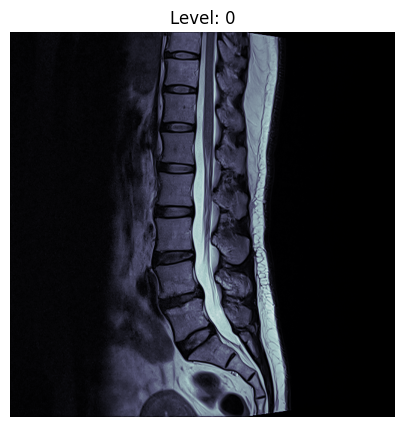

In [ ]:
# Function to open and display DICOM images
def display_dicom_image(image_path, level):
    plt.figure(figsize=(15, 5))  # Adjust figure size if needed
    ds = pydicom.dcmread(image_path)
    plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
    plt.title(f"Level: {level}")
    plt.axis('off')
    plt.show()

for idx, row in df.iterrows():
    display_dicom_image(row["image_path"], row["spinal_canal_stenosis_l5_s1"])
    break

In [ ]:
import pandas as pd
import pydicom
from torch.utils.data import Dataset
from PIL import Image
from sklearn.utils import resample
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

# here there is our CustomDataset class that will handle all functions and call we make

class CustomDataset(Dataset):
    def __init__(self, dataframe, transform):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        image_path = self.dataframe['image_path'].iloc[index]
        dicom_file = pydicom.dcmread(image_path)
        image = dicom_file.pixel_array

        # convert NumPy array to PIL Image
        image = Image.fromarray(image).convert('RGB')
        label = self.dataframe['spinal_canal_stenosis_l5_s1'].iloc[index]

        # check for NaN labels
        if pd.isnull(label):
            raise ValueError(f"Invalid label at index {index}. Label: {label}")

        image = self.transform(image)
        label = torch.tensor(label)

        return image, label

# function that undersample the dataset

def undersample_dataframe(df, label_column, proportion):
    value_counts = df[label_column].value_counts()
    c_max = value_counts.idxmax()
    c_min = value_counts.idxmin()
    value_counts.iloc[c_max] = proportion * value_counts.iloc[c_min]


    dfs = []
    for label, group in df.groupby(label_column):
        n_samples = value_counts[label]
        if len(group) > n_samples:
            group = resample(group, replace=False, n_samples=n_samples, random_state=40)
        dfs.append(group)

    return pd.concat(dfs)

def create_loaders(df, transform, batch_size=8, proportion=None):
     # Splitting the study_ids
    X = df.sort_values(by="study_id").index.get_level_values("study_id").tolist()
    y = df.sort_values(by="study_id")['spinal_canal_stenosis_l5_s1'].tolist()

    train_study_ids, val_study_ids, _, _ = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

     # create train and val DataFrames
    train_df = df.loc[df.index.get_level_values("study_id").isin(train_study_ids)]
    undersample_train_df = undersample_dataframe(train_df, label_column='spinal_canal_stenosis_l5_s1', proportion=proportion)
    val_df = df.loc[df.index.get_level_values("study_id").isin(val_study_ids)]

    # create datasets and data loaders
    train_dataset = CustomDataset(undersample_train_df, transform)
    val_dataset = CustomDataset(val_df, transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

    return train_loader, val_loader

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # resize images to 224x224
    transforms.ToTensor()           # convert images to PyTorch tensors
])

# we define the target class distribution
proportion = 15

# We now create the loaders with the undersampling
train_test_loader, val_loader = create_loaders(
    df,
    transform,
    batch_size=32,
    proportion=proportion
)

print("Show one example:")
X, y = next(iter(train_test_loader))
print("X:", X.shape, "y:", y.shape)
print()

# data train and test
X_train_test = []
y_train_test = []

for x_i, y_i in iter(train_test_loader):
    X_train_test.append(x_i)
    y_train_test.append(y_i)

X_train_test = torch.cat(X_train_test).numpy()
y_train_test = torch.cat(y_train_test).numpy()

# Data validation
X_val = []
y_val = []

for x_i, y_i in iter(val_loader):
    X_val.append(x_i)
    y_val.append(y_i)

X_val = torch.cat(X_val).numpy()
y_val = torch.cat(y_val).numpy()

print("X_train_test:", X_train_test.shape, "y_train_test:", y_train_test.shape)
print(pd.Series(y_train_test.tolist()).value_counts())
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print(pd.Series(y_val.tolist()).value_counts())

Show one example:
X: torch.Size([32, 3, 224, 224]) y: torch.Size([32])

X_train_test: (244, 3, 224, 224) y_train_test: (244,)
0    195
1     36
2     13
Name: count, dtype: int64
X_val: (591, 3, 224, 224) y_val: (591,)
0    570
1     15
2      6
Name: count, dtype: int64


# Models

## Grid Search

Device: cuda


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 129MB/s]
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 147MB/s]


--> Starting Grid Search: EfficientNet_B0
Fitting 2 folds for each of 245 candidates, totalling 490 fits
[CV] END max_epochs=3, optimizer__lr=0.0001, optimizer__weight_decay=0.0001; total time=   2.9s
[CV] END max_epochs=3, optimizer__lr=0.0001, optimizer__weight_decay=0.0001; total time=   1.7s
[CV] END max_epochs=3, optimizer__lr=0.0001, optimizer__weight_decay=0.0005; total time=   1.7s
[CV] END max_epochs=3, optimizer__lr=0.0001, optimizer__weight_decay=0.0005; total time=   1.7s
[CV] END max_epochs=3, optimizer__lr=0.0001, optimizer__weight_decay=0.001; total time=   1.7s
[CV] END max_epochs=3, optimizer__lr=0.0001, optimizer__weight_decay=0.001; total time=   1.8s
[CV] END max_epochs=3, optimizer__lr=0.0001, optimizer__weight_decay=0.005; total time=   1.7s
[CV] END max_epochs=3, optimizer__lr=0.0001, optimizer__weight_decay=0.005; total time=   1.7s
[CV] END max_epochs=3, optimizer__lr=0.0001, optimizer__weight_decay=0.01; total time=   1.7s
[CV] END max_epochs=3, optimizer__lr=

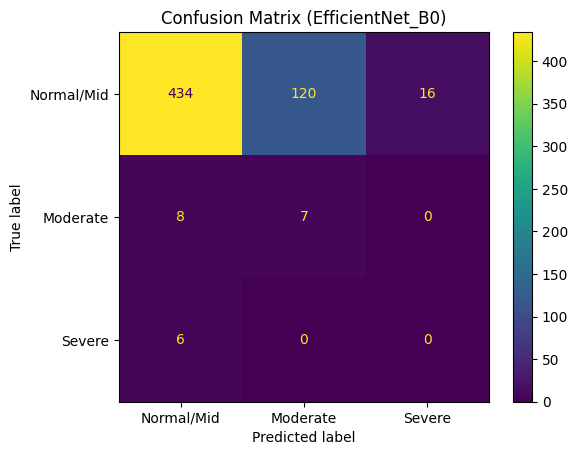

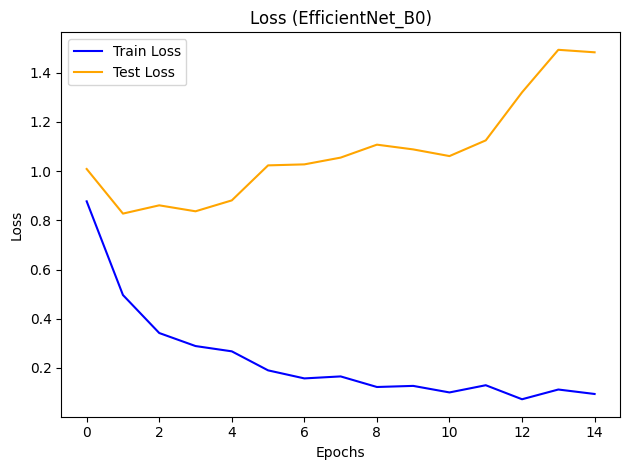

--> Starting Grid Search: ResNet_18
Fitting 2 folds for each of 245 candidates, totalling 490 fits
[CV] END max_epochs=3, optimizer__lr=0.0001, optimizer__weight_decay=0.0001; total time=   1.3s
[CV] END max_epochs=3, optimizer__lr=0.0001, optimizer__weight_decay=0.0001; total time=   1.3s
[CV] END max_epochs=3, optimizer__lr=0.0001, optimizer__weight_decay=0.0005; total time=   1.3s
[CV] END max_epochs=3, optimizer__lr=0.0001, optimizer__weight_decay=0.0005; total time=   1.3s
[CV] END max_epochs=3, optimizer__lr=0.0001, optimizer__weight_decay=0.001; total time=   1.3s
[CV] END max_epochs=3, optimizer__lr=0.0001, optimizer__weight_decay=0.001; total time=   1.3s
[CV] END max_epochs=3, optimizer__lr=0.0001, optimizer__weight_decay=0.005; total time=   1.3s
[CV] END max_epochs=3, optimizer__lr=0.0001, optimizer__weight_decay=0.005; total time=   1.3s
[CV] END max_epochs=3, optimizer__lr=0.0001, optimizer__weight_decay=0.01; total time=   1.3s
[CV] END max_epochs=3, optimizer__lr=0.0001

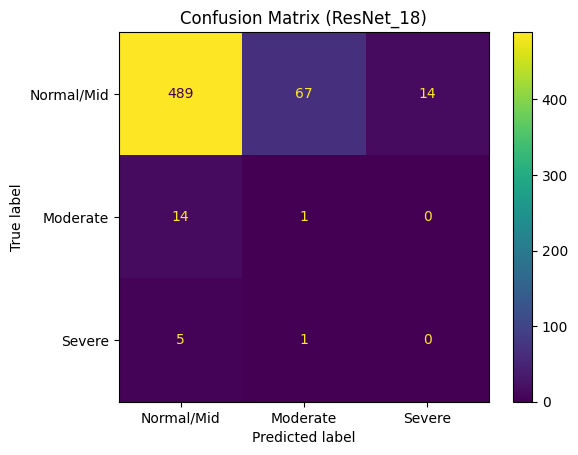

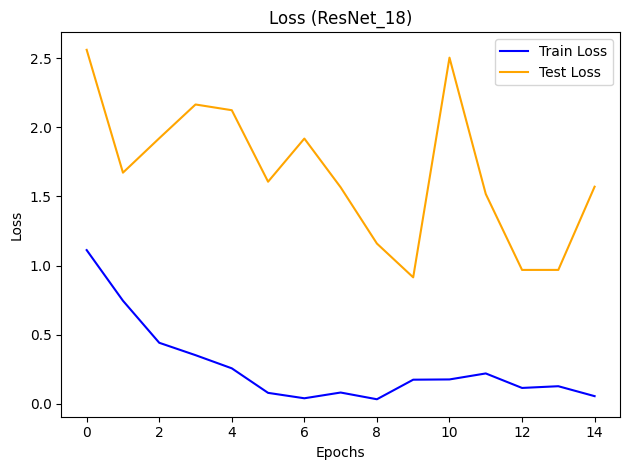

In [ ]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models import resnet18, ResNet18_Weights
from skorch import NeuralNetClassifier
from pytorch_optimizer import Lookahead
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from pandas import DataFrame
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# Stratified cross-validator
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# Models
model_e = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
model_e.classifier[1] = nn.Linear(model_e.classifier[1].in_features, 3, bias=True)

for p in model_e.parameters():
    p.requires_grad = True

model_r = resnet18(weights=ResNet18_Weights.DEFAULT)
model_r.fc = nn.Linear(model_r.fc.in_features, 3, bias=True)

for p in model_r.parameters():
    p.requires_grad = True

models = [
    ('EfficientNet_B0', model_e),
    ('ResNet_18', model_r),
]

# custom optimizer to encapsulate Adam
def make_lookahead(parameters, optimizer_cls, lr, weight_decay, **kwargs):
    optimizer = optimizer_cls(parameters, **kwargs)
    return Lookahead(optimizer=optimizer, lr=lr, weight_decay=weight_decay)

best_models = []
for name, model in models:
    net = NeuralNetClassifier(
        model,
        criterion=nn.CrossEntropyLoss(),
        device=device,
        batch_size=64,
        optimizer=make_lookahead,
        optimizer__optimizer_cls=torch.optim.Adam,
        iterator_train__shuffle=True,
        verbose=0
    )
    
    params = {
        'max_epochs': [3, 6, 9, 12, 15],
        'optimizer__weight_decay': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1],
        'optimizer__lr': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1],
    }

    grid_search = GridSearchCV(net, params, refit=False, cv=skf, scoring='roc_auc_ovr', verbose=2)
    
    print("--> Starting Grid Search:", name)
    grid_search.fit(X_train_test, y_train_test)
    
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    net.set_params(**best_params)
    best_models.append((name, net))
    
    net.fit(X_train_test, y_train_test)
    probabilities = net.predict_proba(X_val)
    predictions = net.predict(X_val)
    
    acc = accuracy_score(y_val, predictions)
    b_acc = balanced_accuracy_score(y_val, predictions)
    prec = precision_score(y_val, predictions, average="weighted")
    rec = recall_score(y_val, predictions, average="weighted")
    roc = roc_auc_score(y_val, probabilities, multi_class="ovr")
    cm =  confusion_matrix(y_val, predictions)

    print("--> Finishing Grid Search:", name)
    print("Best score: {:.3f}, best params: {}".format(best_score, best_params))
    print("Accuracy:", acc)
    print("Balanced Accuracy:", b_acc)
    print("Precision:", prec)
    print("Recall:", rec)
    print("ROC AUC:", roc)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                 display_labels=["Normal/Mid", "Moderate", "Severe"])
    disp.plot()
    plt.title(f'Confusion Matrix ({name})')
    plt.show()
    plt.close()

    train_loss = net.history[:, 'train_loss']
    valid_loss = net.history[:, 'valid_loss']
    
    plt.plot(train_loss, label='Train Loss', color='blue')
    plt.plot(valid_loss, label='Test Loss', color='orange')
    
    plt.title(f'Loss ({name})')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.tight_layout()
    plt.show()
    plt.close()

## Ensemble

Accuracy: 0.8781725888324873
Balanced Accuracy: 0.32514619883040935
Precision: 0.9292034621509907
Recall: 0.8781725888324873
ROC AUC: 0.5482688425122636


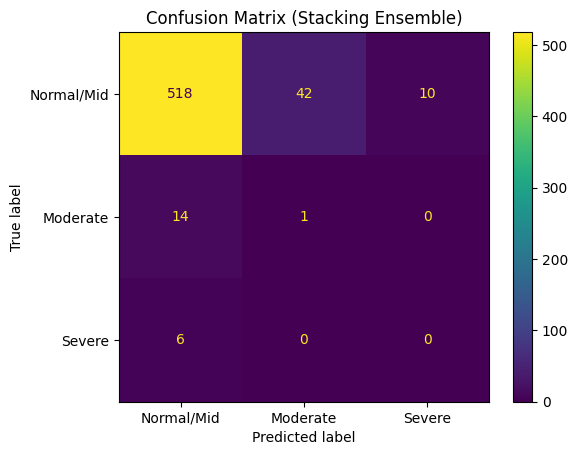

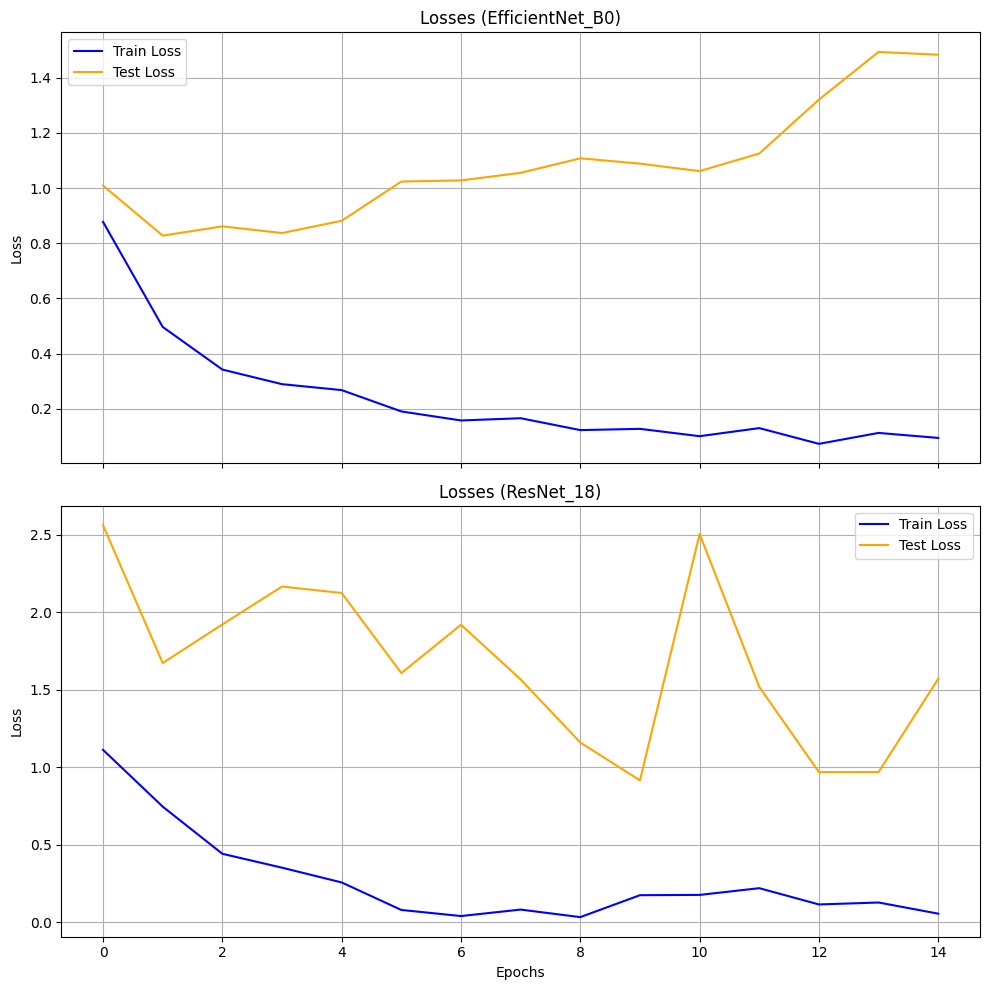

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier

torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

clf = StackingClassifier(
    estimators=best_models,
    final_estimator=RandomForestClassifier(class_weight='balanced', random_state=42),
    cv=skf,
    verbose=2
)
clf.fit(X_train_test, y_train_test)

probabilities = clf.predict_proba(X_val)
predictions = clf.predict(X_val)

acc = accuracy_score(y_val, predictions)
b_acc = balanced_accuracy_score(y_val, predictions)
prec = precision_score(y_val, predictions, average="weighted")
rec = recall_score(y_val, predictions, average="weighted")
roc = roc_auc_score(y_val, probabilities, multi_class="ovr")
cm =  confusion_matrix(y_val, predictions)

print("Accuracy:", acc)
print("Balanced Accuracy:", b_acc)
print("Precision:", prec)
print("Recall:", rec)
print("ROC AUC:", roc)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=["Normal/Mid", "Moderate", "Severe"])
disp.plot()
plt.title("Confusion Matrix (Stacking Ensemble)")
plt.show()
plt.close()

num_models = len(best_models)
fig, axes = plt.subplots(num_models, 1, figsize=(10, 5 * num_models), sharex=True)

for (name, model), ax in zip(best_models, axes):
    train_loss = model.history[:, 'train_loss']
    valid_loss = model.history[:, 'valid_loss']
    
    ax.plot(train_loss, label='Train Loss', color='blue')
    ax.plot(valid_loss, label='Test Loss', color='orange')
    
    ax.set_title(f'Losses ({name})')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True)

plt.xlabel('Epochs')
plt.tight_layout()
plt.show()
plt.close()